# Solution for the *Child Mind Institute — Problematic Internet Use* competition

Nomad Team:

- Dao Thi Binh An - 22028326
- Bui Thi Huyen Tam - 22028214
- Doan Minh Quan - 20020152

In [15]:
#import basic libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt, matplotlib.gridspec as gridspe
import seaborn as sns
import polars as pl

from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import numpy as np
import seaborn as sns
import lightgbm
from colorama import Fore, Style

import optuna
import os
from multiprocessing import Pool, cpu_count
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy.optimize import minimize

# 1. Exploratory Data Analysis (EDA)

## Dataset Overview

In [3]:
dic = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv")
train_df = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/train.csv")
test_df = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/test.csv")

In [ ]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', None) 
dic.head()

In [5]:
# Summarise data_dictionary
grouped = dic.groupby('Instrument', sort=False)['Field'].apply(lambda x: ', '.join(x)).reset_index()
grouped['NumFields'] = dic.groupby('Instrument', sort=False).size().values
grouped = grouped.style.set_properties(**{'text-align': 'left'}, subset=['Instrument', 'Field', 'NumFields']) \
        .set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}])

grouped

,Instrument,Field,NumFields
0,Identifier,id,1
1,Demographics,"Basic_Demos-Enroll_Season, Basic_Demos-Age, Basic_Demos-Sex",3
2,Children's Global Assessment Scale,"CGAS-Season, CGAS-CGAS_Score",2
3,Physical Measures,"Physical-Season, Physical-BMI, Physical-Height, Physical-Weight, Physical-Waist_Circumference, Physical-Diastolic_BP, Physical-HeartRate, Physical-Systolic_BP",8
4,FitnessGram Vitals and Treadmill,"Fitness_Endurance-Season, Fitness_Endurance-Max_Stage, Fitness_Endurance-Time_Mins, Fitness_Endurance-Time_Sec",4
5,FitnessGram Child,"FGC-Season, FGC-FGC_CU, FGC-FGC_CU_Zone, FGC-FGC_GSND, FGC-FGC_GSND_Zone, FGC-FGC_GSD, FGC-FGC_GSD_Zone, FGC-FGC_PU, FGC-FGC_PU_Zone, FGC-FGC_SRL, FGC-FGC_SRL_Zone, FGC-FGC_SRR, FGC-FGC_SRR_Zone, FGC-FGC_TL, FGC-FGC_TL_Zone",15
6,Bio-electric Impedance Analysis,"BIA-Season, BIA-BIA_Activity_Level_num, BIA-BIA_BMC, BIA-BIA_BMI, BIA-BIA_BMR, BIA-BIA_DEE, BIA-BIA_ECW, BIA-BIA_FFM, BIA-BIA_FFMI, BIA-BIA_FMI, BIA-BIA_Fat, BIA-BIA_Frame_num, BIA-BIA_ICW, BIA-BIA_LDM, BIA-BIA_LST, BIA-BIA_SMM, BIA-BIA_TBW",17
7,Physical Activity Questionnaire (Adolescents),"PAQ_A-Season, PAQ_A-PAQ_A_Total",2
8,Physical Activity Questionnaire (Children),"PAQ_C-Season, PAQ_C-PAQ_C_Total",2
9,Parent-Child Internet Addiction Test,"PCIAT-Season, PCIAT-PCIAT_01, PCIAT-PCIAT_02, PCIAT-PCIAT_03, PCIAT-PCIAT_04, PCIAT-PCIAT_05, PCIAT-PCIAT_06, PCIAT-PCIAT_07, PCIAT-PCIAT_08, PCIAT-PCIAT_09, PCIAT-PCIAT_10, PCIAT-PCIAT_11, PCIAT-PCIAT_12, PCIAT-PCIAT_13, PCIAT-PCIAT_14, PCIAT-PCIAT_15, PCIAT-PCIAT_16, PCIAT-PCIAT_17, PCIAT-PCIAT_18, PCIAT-PCIAT_19, PCIAT-PCIAT_20, PCIAT-PCIAT_Total",22


In [6]:
# training data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

2736 non-null in sii => 
sii missing is about 30% (accepted to remove), so only use part with sii valid to train the supervised model for accurately.

In [3]:
target_labels = ['None', 'Mild', 'Moderate', 'Severe']
season_dtype = pl.Enum(['Spring', 'Summer', 'Fall', 'Winter'])

train = (
    pl.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
    .with_columns(pl.col('^.*Season$').cast(season_dtype))
)

test = (
    pl.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
    .with_columns(pl.col('^.*Season$').cast(season_dtype))
)


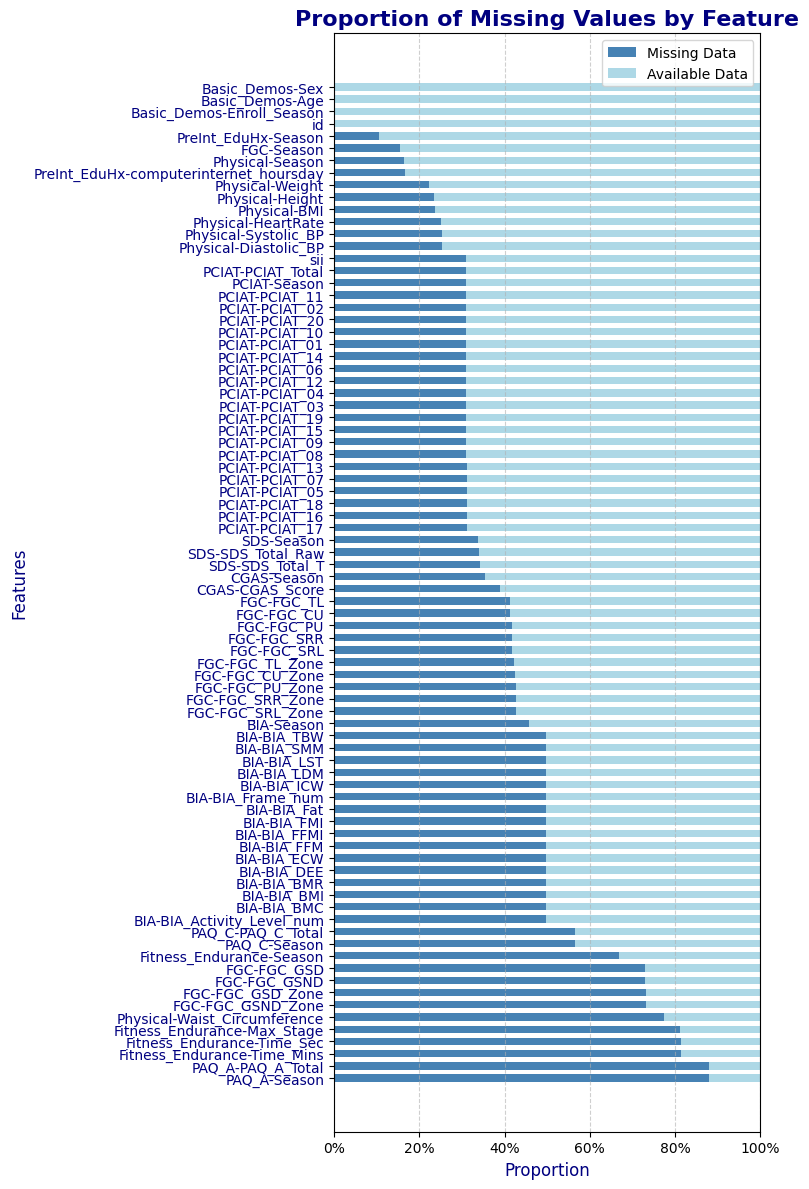

In [6]:
missing_count = (
    train
    .null_count()
    .transpose(include_header=True,
               header_name='feature',
               column_names=['null_count'])
    .sort('null_count', descending=True)
    .with_columns((pl.col('null_count') / len(train)).alias('null_ratio'))
)

plt.figure(figsize=(8, 12))
plt.title('Proportion of Missing Values by Feature', fontsize=16, fontweight='bold', color='navy')

null_ratios = missing_count.get_column('null_ratio')
available_ratios = 1 - null_ratios
features = missing_count.get_column('feature')

bar_width = 0.6
y_positions = np.arange(len(features))

plt.barh(
    y_positions, 
    null_ratios, 
    color='steelblue', 
    height=bar_width, 
    label='Missing Data'
)

plt.barh(
    y_positions, 
    available_ratios, 
    left=null_ratios, 
    color='lightblue',  
    height=bar_width, 
    label='Available Data'
)


plt.yticks(
    y_positions, 
    features, 
    fontsize=10, 
    color='navy'
)
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlim(0, 1)

plt.xlabel('Proportion', fontsize=12, color='navy')
plt.ylabel('Features', fontsize=12, color='navy')
plt.legend(fontsize=10, loc='upper right')

plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [10]:
#Testing data
test_df.info()
# 58 fields measured (excluding id) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 59 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      20 non-null     object 
 1   Basic_Demos-Enroll_Season               20 non-null     object 
 2   Basic_Demos-Age                         20 non-null     int64  
 3   Basic_Demos-Sex                         20 non-null     int64  
 4   CGAS-Season                             10 non-null     object 
 5   CGAS-CGAS_Score                         8 non-null      float64
 6   Physical-Season                         14 non-null     object 
 7   Physical-BMI                            13 non-null     float64
 8   Physical-Height                         13 non-null     float64
 9   Physical-Weight                         13 non-null     float64
 10  Physical-Waist_Circumference            5 non-null      float64


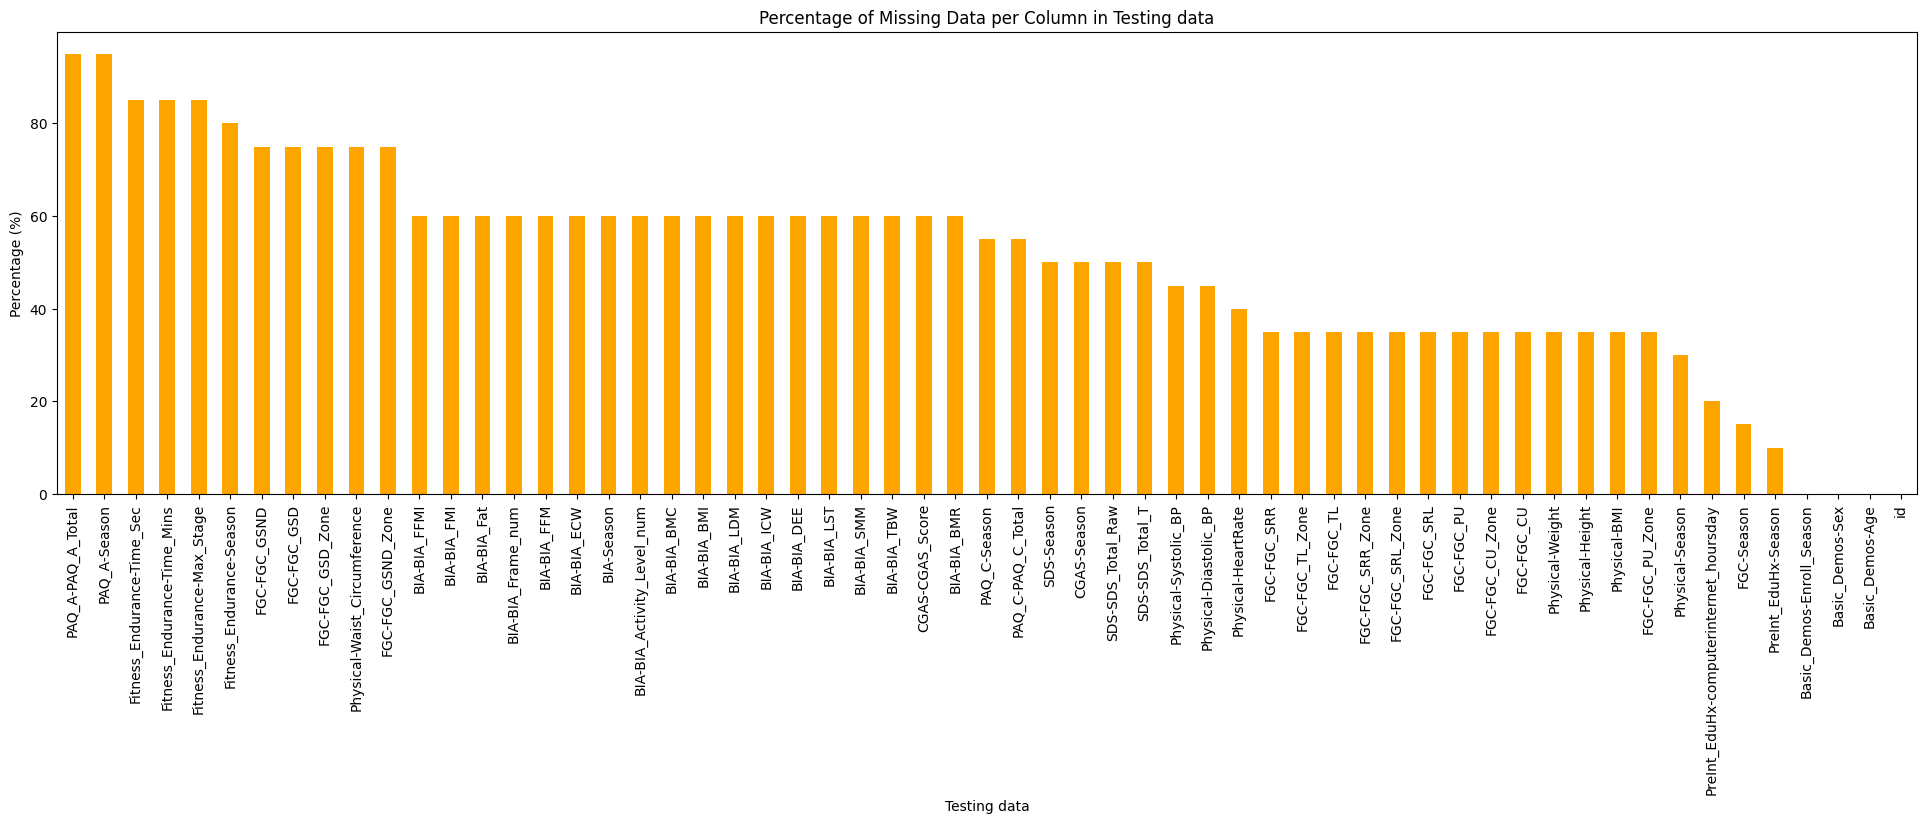

In [12]:
missing_percentage_test = (test_df.isnull().sum() / len(test_df)) * 100 # calculate % missing data

missing_percentage_test.sort_values(ascending=False).plot(kind='bar', color='orange', figsize=(24, 6))
plt.title('Percentage of Missing Data per Column in Testing data')
plt.ylabel('Percentage (%)')
plt.xlabel('Testing data');

## Feature Classification & Distribution

In [14]:
# Identify the type of fields (features to train)
def print_column_info(column_type, column_name):
    cols = dic[dic['Type'] == column_type]['Field']
    print(f"{column_name}: {len(cols)}")
    print(cols.values)
    print("\n")

print_column_info('float', 'Continuous')
print_column_info('int', 'Discrete')
print_column_info('str', 'Categorical')
print_column_info('categorical int', 'Categorical Int')


Continuous: 24
['Basic_Demos-Age' 'Physical-BMI' 'Physical-Height' 'Physical-Weight'
 'FGC-FGC_GSND' 'FGC-FGC_GSD' 'FGC-FGC_SRL' 'FGC-FGC_SRR' 'BIA-BIA_BMC'
 'BIA-BIA_BMI' 'BIA-BIA_BMR' 'BIA-BIA_DEE' 'BIA-BIA_ECW' 'BIA-BIA_FFM'
 'BIA-BIA_FFMI' 'BIA-BIA_FMI' 'BIA-BIA_Fat' 'BIA-BIA_ICW' 'BIA-BIA_LDM'
 'BIA-BIA_LST' 'BIA-BIA_SMM' 'BIA-BIA_TBW' 'PAQ_A-PAQ_A_Total'
 'PAQ_C-PAQ_C_Total']


Discrete: 14
['CGAS-CGAS_Score' 'Physical-Waist_Circumference' 'Physical-Diastolic_BP'
 'Physical-HeartRate' 'Physical-Systolic_BP' 'Fitness_Endurance-Max_Stage'
 'Fitness_Endurance-Time_Mins' 'Fitness_Endurance-Time_Sec' 'FGC-FGC_CU'
 'FGC-FGC_PU' 'FGC-FGC_TL' 'PCIAT-PCIAT_Total' 'SDS-SDS_Total_Raw'
 'SDS-SDS_Total_T']


Categorical: 12
['id' 'Basic_Demos-Enroll_Season' 'CGAS-Season' 'Physical-Season'
 'Fitness_Endurance-Season' 'FGC-Season' 'BIA-Season' 'PAQ_A-Season'
 'PAQ_C-Season' 'PCIAT-Season' 'SDS-Season' 'PreInt_EduHx-Season']


Categorical Int: 31
['Basic_Demos-Sex' 'FGC-FGC_CU_Zone' 'FGC-FGC_GSN

## Distribution of features
### Distribution of numerical features

In [15]:

usable_train_df.describe()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
count,2736.000000,2736.000000,2342.000000,2527.000000,2530.000000,2572.000000,483.000000,2478.000000,2486.000000,2478.000000,...,2728.000000,2725.000000,2728.000000,2730.000000,2733.000000,2736.000000,2527.000000,2525.000000,2654.000000,2736.000000
mean,10.238670,0.364401,65.159266,19.125667,55.897051,87.839592,26.625259,69.755044,81.823411,117.127926,...,1.452346,1.627890,1.613636,1.158974,0.943652,27.896199,40.977839,57.647525,1.015072,0.580409
std,3.427982,0.481350,11.811050,4.909305,7.394938,43.353079,5.230213,13.790203,13.769816,17.221707,...,1.495600,1.445622,1.529178,1.343661,1.185460,20.338853,10.231384,13.042815,1.080861,0.771122
min,5.000000,0.000000,25.000000,0.000000,36.000000,0.000000,19.000000,11.000000,27.000000,49.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,38.000000,0.000000,0.000000
25%,8.000000,0.000000,59.000000,15.773447,50.050000,57.200000,23.000000,61.000000,73.000000,107.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,33.000000,47.000000,0.000000,0.000000
50%,10.000000,0.000000,65.000000,17.819010,55.000000,75.800000,26.000000,68.000000,81.000000,114.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,26.000000,39.000000,55.000000,1.000000,0.000000
75%,12.000000,1.000000,75.000000,21.172311,61.750000,111.450000,29.000000,76.000000,91.000000,125.000000,...,2.000000,3.000000,2.000000,2.000000,1.000000,41.000000,46.000000,64.000000,2.000000,1.000000
max,22.000000,1.000000,95.000000,46.102914,78.500000,315.000000,50.000000,179.000000,138.000000,203.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,93.000000,96.000000,100.000000,3.000000,3.000000


Look at some sample:

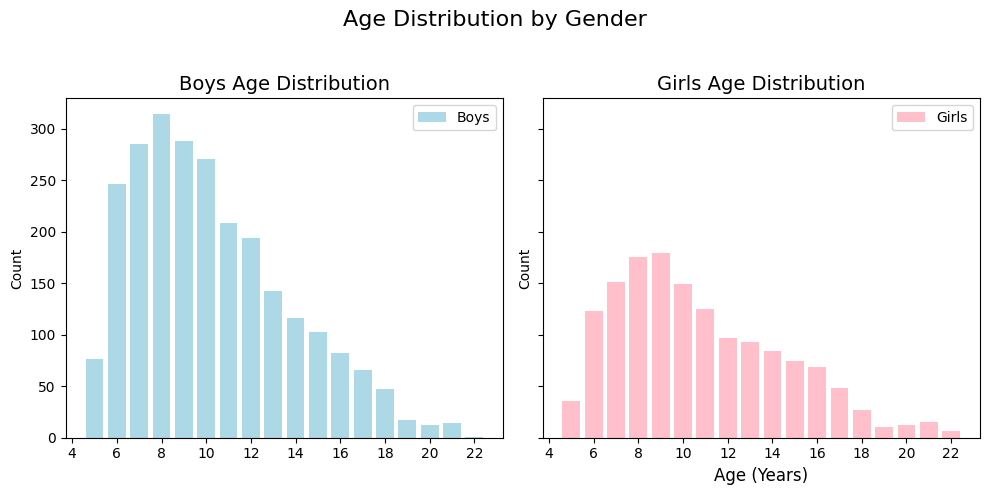

In [7]:
_, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

for sex in range(2):
    ax = axs[sex]
    # Filter data by gender and count the occurrences of each age
    vc = train.filter(pl.col('Basic_Demos-Sex') == sex).get_column('Basic_Demos-Age').value_counts()
    
    ax.bar(vc.get_column('Basic_Demos-Age'),
           vc.get_column('count'),
           color=['lightblue', 'pink'][sex],
           label=['Boys', 'Girls'][sex])
    
    ax.set_ylabel('Count')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_title(f'{["Boys", "Girls"][sex]} Age Distribution', fontsize=14)
    ax.legend()

plt.suptitle('Age Distribution by Gender', fontsize=16)

axs[1].set_xlabel('Age (Years)', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()


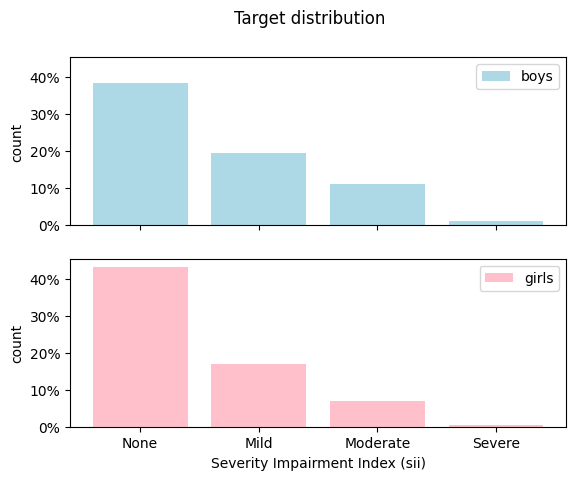

In [8]:
_, axs = plt.subplots(2, 1, sharex=True, sharey=True)
for sex in range(2):
    ax = axs.ravel()[sex]
    vc = train.filter(pl.col('Basic_Demos-Sex') == sex).get_column('sii').value_counts()
    ax.bar(vc.get_column('sii'),
           vc.get_column('count') / vc.get_column('count').sum(),
           color=['lightblue', 'pink'][sex],
           label=['boys', 'girls'][sex])
    ax.set_xticks(np.arange(4), target_labels)
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    ax.set_ylabel('count')
    ax.legend()
plt.suptitle('Target distribution')
axs.ravel()[1].set_xlabel('Severity Impairment Index (sii)')
plt.show()

### Distribution categorical features

In [16]:
usable_train_df.select_dtypes(include=["object"]).describe()

,id,Basic_Demos-Enroll_Season,CGAS-Season,Physical-Season,Fitness_Endurance-Season,FGC-Season,BIA-Season,PAQ_A-Season,PAQ_C-Season,PCIAT-Season,SDS-Season,PreInt_EduHx-Season
count,2736,2736,2342,2595,1260,2647,1844,363,1440,2736,2527,2719
unique,2736,4,4,4,4,4,4,4,4,4,4,4
top,00008ff9,Spring,Spring,Spring,Spring,Spring,Summer,Winter,Spring,Spring,Spring,Spring
freq,1,734,665,709,377,771,585,98,405,762,692,728


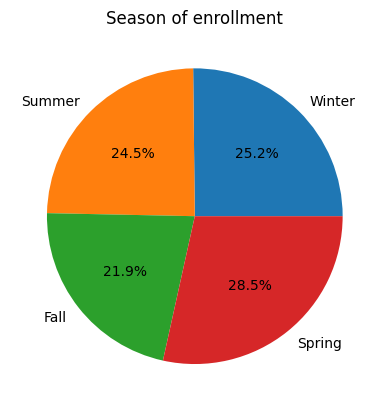

In [9]:
# The four seasons of enrollment have similar frequencies:
vc = train.get_column('Basic_Demos-Enroll_Season').value_counts()
plt.pie(vc.get_column('count'), labels=vc.get_column('Basic_Demos-Enroll_Season'),  autopct='%1.1f%%')
plt.title('Season of enrollment')
plt.show()

### Distribution of "Sii"

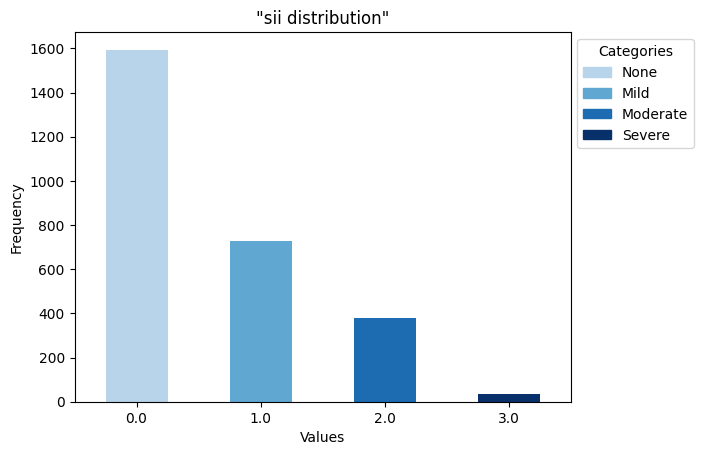

In [17]:
# sii distribution → sii is imbalanced, half of it is 0
sii_counts = usable_train_df['sii'].value_counts()
colors = plt.cm.Blues(np.linspace(0.3, 1, len(sii_counts)))

#plt.figure(figsize=(12, 6))
sii_counts.plot(kind='bar', color=colors)
plt.title('"sii distribution"')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
legend_labels = ['None', 'Mild', 'Moderate', 'Severe']
colors_for_legend = colors
plt.legend(handles=[plt.Rectangle((0, 0), 1, 1, color=color) for color in colors_for_legend],
           labels=legend_labels, title="Categories", loc='upper left', bbox_to_anchor=(1, 1));

##  Correlation Analysis

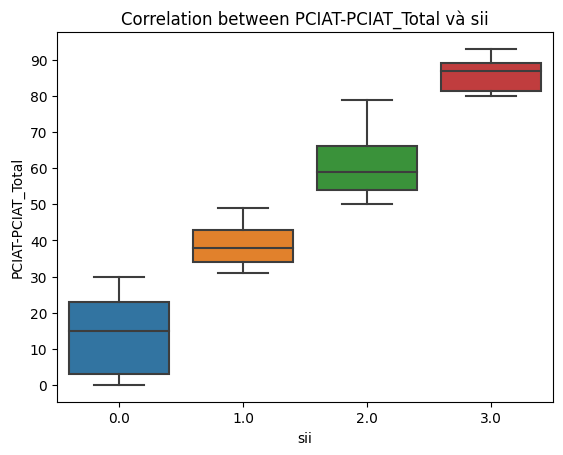

In [19]:
sns.boxplot(x='sii', y='PCIAT-PCIAT_Total', data=usable_train_df)
plt.title('Correlation between PCIAT-PCIAT_Total và sii')
plt.xlabel('sii')
plt.ylabel('PCIAT-PCIAT_Total')
y_ticks = np.arange(usable_train_df['PCIAT-PCIAT_Total'].min(), usable_train_df['PCIAT-PCIAT_Total'].max(), 10)
plt.yticks(y_ticks);

In [13]:
# find the difference between 2 files
print([f for f in train_df.columns if f not in test_df.columns])
# columns_train = set(usable_train_df.columns)
# columns_test = set(test_df.columns)
# difference = sorted(list(columns_train - columns_test)) #Find the difference columns in 2 data files
# print(difference) # 23

['PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'sii']


The target ```sii``` is available exactly for those participants for whom we have results of the Parent-Child Internet Addiction Test (PCIAT), and it is a function of the PCIAT total score.
* 0-30 Normal (0)
* 31-49 Mild (1)
* 50-79 Moderate (2)
* 80-100 Severe (3)

Proof: https://digitalwellnesslab.org/wp-content/uploads/Scoring-Overview.pdf

Basic_Demos-Age                           0.409559
Physical-BMI                              0.240858
Physical-Height                           0.420765
Physical-Weight                           0.353048
FGC-FGC_GSND                              0.146813
FGC-FGC_GSD                               0.160472
FGC-FGC_SRL                              -0.091221
FGC-FGC_SRR                              -0.077836
BIA-BIA_BMI                               0.248060
BIA-BIA_DEE                               0.053094
BIA-BIA_FFMI                              0.109694
BIA-BIA_FMI                               0.085863
BIA-BIA_ICW                               0.052593
BIA-BIA_LST                               0.075623
BIA-BIA_SMM                               0.052912
CGAS-CGAS_Score                          -0.070542
Physical-Waist_Circumference              0.327013
Physical-Diastolic_BP                     0.069321
Physical-Systolic_BP                      0.147081
Fitness_Endurance-Time_Mins    

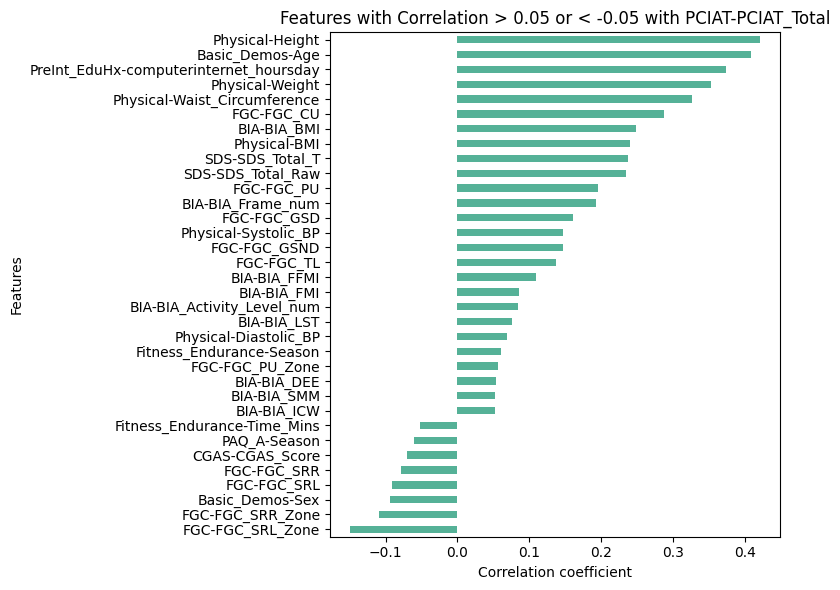

In [20]:
# Check correlation between numerical features and PCIAT Total Scores

corr_matrix = usable_train_df[[
    'Basic_Demos-Age', 'Physical-BMI', 'Physical-Height', 'Physical-Weight',
 'FGC-FGC_GSND' ,'FGC-FGC_GSD', 'FGC-FGC_SRL', 'FGC-FGC_SRR', 'BIA-BIA_BMC',
 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE' ,'BIA-BIA_ECW', 'BIA-BIA_FFM',
 'BIA-BIA_FFMI' ,'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_ICW' ,'BIA-BIA_LDM',
 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total',
 'PAQ_C-PAQ_C_Total', 'CGAS-CGAS_Score' ,'Physical-Waist_Circumference', 'Physical-Diastolic_BP',
 'Physical-HeartRate', 'Physical-Systolic_BP' ,'Fitness_Endurance-Max_Stage',
 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec' ,'FGC-FGC_CU',
 'FGC-FGC_PU', 'FGC-FGC_TL' ,'PCIAT-PCIAT_Total', 'SDS-SDS_Total_Raw',
 'SDS-SDS_Total_T', 'PreInt_EduHx-computerinternet_hoursday',
    
    'Basic_Demos-Sex', 'FGC-FGC_CU_Zone' ,'FGC-FGC_GSND_Zone',
 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone' ,'FGC-FGC_SRL_Zone',
 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num',
 'BIA-BIA_Frame_num', 
    
    'Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season',
    'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season',
    'PAQ_C-Season', 'PCIAT-Season', 'SDS-Season', 'PreInt_EduHx-Season'
]].corr()

sii_corr = corr_matrix['PCIAT-PCIAT_Total'].drop('PCIAT-PCIAT_Total')
filtered_corr = sii_corr[(sii_corr > 0.05) | (sii_corr < -0.05)]

print(filtered_corr)

plt.figure(figsize=(8, 6))
filtered_corr.sort_values().plot(kind='barh', color='#55B197')
plt.title('Features with Correlation > 0.05 or < -0.05 with PCIAT-PCIAT_Total')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

## Actigraphy Data Insights

> [Actigraphy](https://en.wikipedia.org/wiki/Actigraphy) is a non-invasive method of monitoring human rest/activity cycles. A small actigraph unit, also called an actimetry sensor, is worn for a week or more to measure gross motor activity. The unit is usually in a wristwatch-like package worn on the wrist. The movements the actigraph unit undergoes are continually recorded and some units also measure light exposure. (Wikipedia)

We have actigraphy files for a quarter of the participants (996 to be precise). The file name is always `part-0.parquet`. 

Looking at the file of participant `id=0417c91e`, a six-year old right-handed girl, we see that this participant started to use the accelerometer on a Tuesday (weekday=2) of the second quarter of the year at second 44100 of the day (12:15 PM), 5 days after the PCIAT test. She gave the accelerometer back on the 53rd day after the PCIAT test, a Monday of the third quarter, at 9:08 AM.

The competition data page says that `time_of_day` is in format `%H:%M:%S.%9f`. This is obviously not true. `time_of_day` is measured in nanoseconds since midnight.

In [10]:
actigraphy = pl.read_parquet('/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id=0417c91e/part-0.parquet')
actigraphy.head()

step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
u32,f32,f32,f32,f32,f32,f32,f32,f32,i64,i8,i8,f32
0,0.014375,-0.020112,-0.995358,0.00106,-88.445251,0.0,41.0,4195.0,44100000000000,2,2,5.0
1,0.014167,-0.023278,-0.996164,0.000289,-88.3722,0.0,41.0,4194.833496,44105000000000,2,2,5.0
2,0.014036,-0.022964,-0.99632,0.000301,-88.356422,0.0,41.5,4194.666504,44110000000000,2,2,5.0
3,0.013593,-0.022048,-0.996762,0.002278,-88.575943,0.0,37.5,4194.5,44115000000000,2,2,5.0
4,-0.061772,-0.065317,-0.973063,0.092321,-88.391273,0.0,55.666668,4199.0,44780000000000,2,2,5.0


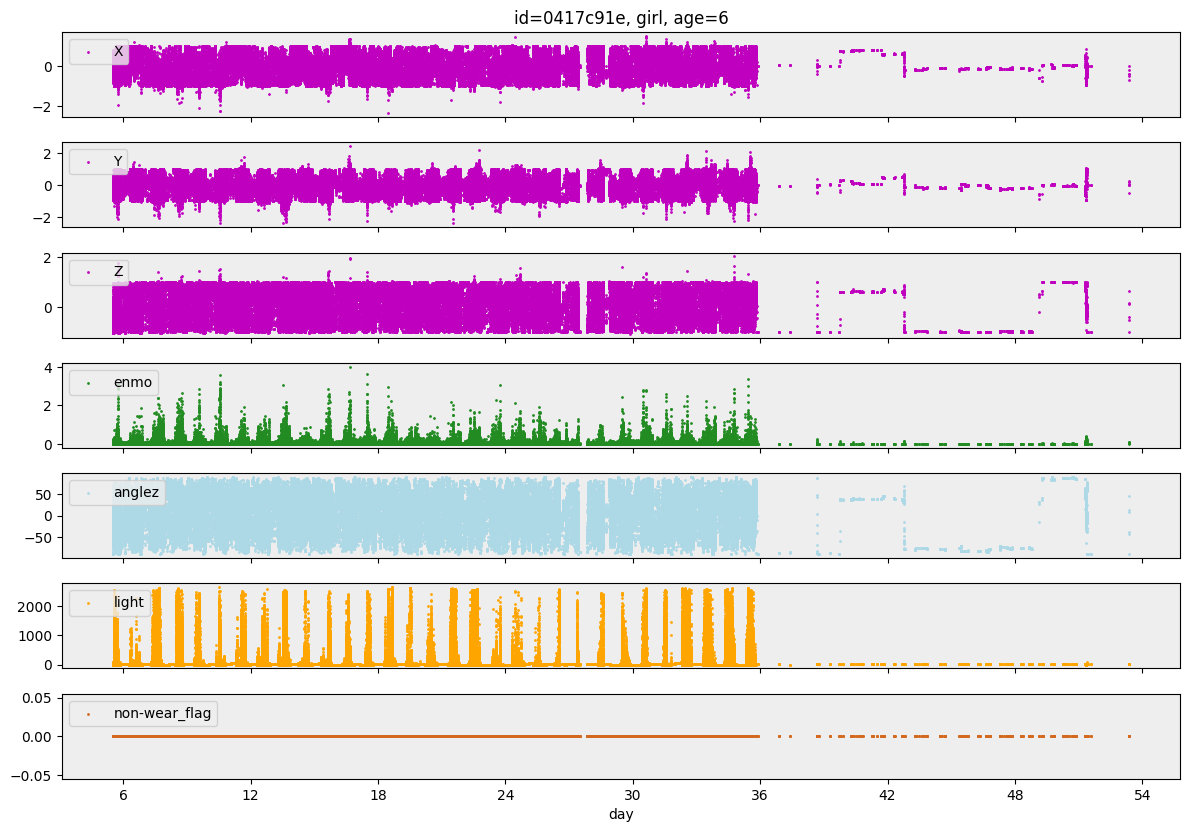

In [11]:
def analyze_actigraphy(id, only_one_week=False, small=False):
    actigraphy = pl.read_parquet(f'/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet/id={id}/part-0.parquet')
    day = actigraphy.get_column('relative_date_PCIAT') + actigraphy.get_column('time_of_day') / 86400e9
    sample = train.filter(pl.col('id') == id)
    age = sample.get_column('Basic_Demos-Age').item()
    sex = ['boy', 'girl'][sample.get_column('Basic_Demos-Sex').item()]
    actigraphy = (
        actigraphy
        .with_columns(
            (day.diff() * 86400).alias('diff_seconds'),
            (np.sqrt(np.square(pl.col('X')) + np.square(pl.col('Y')) + np.square(pl.col('Z'))).alias('norm'))
        )
    )

    if only_one_week:
        start = np.ceil(day.min())
        mask = (start <= day.to_numpy()) & (day.to_numpy() <= start + 7*3)
        mask &= ~ actigraphy.get_column('non-wear_flag').cast(bool).to_numpy()
    else:
        mask = np.full(len(day), True)
        
    if small:
        timelines = [
            ('enmo', 'forestgreen'),
            ('light', 'orange'),
        ]
    else:
        timelines = [
            ('X', 'm'),
            ('Y', 'm'),
            ('Z', 'm'),
#             ('norm', 'c'),
            ('enmo', 'forestgreen'),
            ('anglez', 'lightblue'),
            ('light', 'orange'),
            ('non-wear_flag', 'chocolate')
    #         ('diff_seconds', 'k'),
        ]
        
    _, axs = plt.subplots(len(timelines), 1, sharex=True, figsize=(12, len(timelines) * 1.1 + 0.5))
    for ax, (feature, color) in zip(axs, timelines):
        ax.set_facecolor('#eeeeee')
        ax.scatter(day.to_numpy()[mask],
                   actigraphy.get_column(feature).to_numpy()[mask],
                   color=color, label=feature, s=1)
        ax.legend(loc='upper left', facecolor='#eeeeee')
        if feature == 'diff_seconds':
            ax.set_ylim(-0.5, 20.5)
    axs[-1].set_xlabel('day')
    axs[-1].xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    axs[0].set_title(f'id={id}, {sex}, age={age}')
    plt.show()

analyze_actigraphy('0417c91e', only_one_week=False)

We can plot diagrams of the time series in this file. We can see:
1. We clearly see a daily pattern.
2. We see that the girl wore the accelerometer for 31 days and then took it off.
3. The dataset has a non-wear_flag column, but that flag is always zero for this participant. 
4. The girl is in an environment where the illuminance exceeds 2500 [lux](https://en.wikipedia.org/wiki/Lux) every day (the device cannot measure more than 2500 lux). Such a high illuminance means that she is outdoors or in a room with huge windows.
5. The girl moves a lot: she has enmo values above 2 almost every day.
6. The time series usually contain measurements every 5 seconds, but some time steps are missing. It is not documented under what conditions time steps are skipped.


# 2. Preprocessing & Feature engineering


## Handling Missing Data in the "sii" Column

In [7]:
usable_train_df = train_df.dropna(subset='sii')
# usable_train_df.info()

## Encoding Seasonal Columns

In [18]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
columns_to_encode = [
    'Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season',
    'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season',
    'PAQ_C-Season', 'PCIAT-Season', 'SDS-Season', 'PreInt_EduHx-Season'
]

for col in columns_to_encode:
    encoder = LabelEncoder()
    non_null_values = train_df[col].dropna().astype(str)
    encoder.fit(non_null_values)
    train_df[col] = train_df[col].map(lambda x: encoder.transform([str(x)])[0] if pd.notna(x) else np.nan)

test_col_to_encode = [col for col in columns_to_encode if col != 'PCIAT-Season']

for col in test_col_to_encode:
    test_df[col] = test_df[col].map(lambda x: encoder.transform([str(x)])[0] if pd.notna(x) else np.nan)

usable_train_df = train_df.dropna(subset=['sii'])

## Processing Actigraphy Data

In [21]:
from concurrent.futures import ThreadPoolExecutor
from pathlib import Path

# Function to process a single file
def process_file(filename, dirname):
    filepath = Path(dirname) / filename / 'part-0.parquet'
    df = pd.read_parquet(filepath)
    df = df.drop(columns='step') 
    return df.describe().values.reshape(-1), filename.split('=')[1]

# Function to load and process all files in parallel
def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    num_threads = min(len(ids), 
                      os.cpu_count() * 4) # add more CPU
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    stats, indexes = zip(*results)
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df

# AutoEncoder class
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim * 3), nn.ReLU(),
            nn.Linear(encoding_dim * 3, encoding_dim * 2), nn.ReLU(),
            nn.Linear(encoding_dim * 2, encoding_dim), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim * 2), nn.ReLU(),
            nn.Linear(input_dim * 2, input_dim * 3), nn.ReLU(),
            nn.Linear(input_dim * 3, input_dim), nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Function to train and use the AutoEncoder
def autoencode_data(df, encoding_dim=50, epochs=50, batch_size=32):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    data_tensor = torch.FloatTensor(df_scaled)
    input_dim = data_tensor.shape[1]
    
    autoencoder = AutoEncoder(input_dim, encoding_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

    for epoch in range(epochs):
        for i in range(0, len(data_tensor), batch_size):
            batch = data_tensor[i:i + batch_size]
            optimizer.zero_grad()
            loss = criterion(autoencoder(batch), batch)
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

    with torch.no_grad():
        encoded_data = autoencoder.encoder(data_tensor).numpy()

    return pd.DataFrame(encoded_data, columns=[f'Acti_{i + 1}' for i in range(encoded_data.shape[1])])

In [22]:
#read
train_acti = load_time_series('/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet')
test_acti = load_time_series('/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet')

#encode
train_ts = autoencode_data(train_acti.drop('id', axis=1))
test_ts = autoencode_data(test_acti.drop('id', axis=1))

train_ts['id'] = train_acti['id']
test_ts['id'] = test_acti['id']

100%|██████████| 2/2 [00:00<00:00, 10.23it/s]


Epoch [10/50], Loss: 1.6248
Epoch [20/50], Loss: 1.5532
Epoch [30/50], Loss: 1.5339
Epoch [40/50], Loss: 1.4837
Epoch [50/50], Loss: 1.4819
Epoch [10/50], Loss: 1.0255
Epoch [20/50], Loss: 0.7277
Epoch [30/50], Loss: 0.4297
Epoch [40/50], Loss: 0.4271
Epoch [50/50], Loss: 0.4271


## Feature selection

In [23]:
# choose features to train (58 features in Test)
featuresCols = [
    'Basic_Demos-Age', 'Physical-BMI', 'Physical-Height', 'Physical-Weight',
    'FGC-FGC_GSND', 'FGC-FGC_GSD', 'FGC-FGC_SRL', 'FGC-FGC_SRR', 'BIA-BIA_BMC',
    'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
    'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_ICW', 'BIA-BIA_LDM',
    'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total',
    'PAQ_C-PAQ_C_Total', 'CGAS-CGAS_Score', 'Physical-Waist_Circumference',
    'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
    'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins',
    'Fitness_Endurance-Time_Sec', 'FGC-FGC_CU', 'FGC-FGC_PU', 'FGC-FGC_TL',
    'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T', 'Basic_Demos-Enroll_Season',
    'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season',
    'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season',
    'PreInt_EduHx-Season', 'Basic_Demos-Sex', 'FGC-FGC_CU_Zone',
    'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone',
    'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone',
    'BIA-BIA_Activity_Level_num', 'BIA-BIA_Frame_num',
    'PreInt_EduHx-computerinternet_hoursday'
]

In [24]:
#filter features has >50% missing data
columns_with_missing = missing_percentage[missing_percentage > 50].index
missCols = usable_train_df[columns_with_missing]
# print(missCols)

selectedFeatures = list(set(featuresCols) - set(missCols))
selected_df = usable_train_df[["id"] + [col for col in selectedFeatures if col != "id"]]

test = test_df[["id"]+ selectedFeatures]
# test.head()

In [25]:
selected_df.shape

(2736, 48)

In [26]:
selected_df = selected_df.merge(train_ts, on='id', how='left')
test = test.merge(test_ts, on='id', how='left')

In [27]:
selected_df = selected_df.drop(columns='id')

In [28]:
selected_df.shape


(2736, 97)

## Handle missing data

In [29]:
from sklearn.experimental import enable_iterative_imputer  # Cần import trước khi sử dụng IterativeImputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(max_iter=25, random_state=42)

selected_df = pd.DataFrame(imputer.fit_transform(selected_df), columns=selected_df.columns)

selected_df.head()


,BIA-BIA_BMI,BIA-BIA_ICW,BIA-BIA_Activity_Level_num,FGC-FGC_SRR_Zone,FGC-FGC_SRL_Zone,PAQ_C-PAQ_C_Total,Physical-Season,BIA-BIA_Fat,FGC-FGC_CU_Zone,SDS-SDS_Total_T,...,Acti_41,Acti_42,Acti_43,Acti_44,Acti_45,Acti_46,Acti_47,Acti_48,Acti_49,Acti_50
0,16.879200,24.434900,2.00000,0.0,0.0,2.807041,0.0,9.213770,0.0,57.725618,...,0.0,0.816670,3.187318,0.331796,0.086919,1.156686,2.554612,1.497017,2.423628,1.070260
1,14.037100,21.035200,2.00000,1.0,1.0,2.340000,0.0,3.970850,0.0,64.000000,...,0.0,0.801500,3.048432,0.226777,0.013192,1.315738,2.347959,1.258931,2.041109,0.906706
2,19.232339,33.134553,2.56869,1.0,1.0,2.170000,0.0,5.715816,1.0,54.000000,...,0.0,0.889917,3.110354,0.476154,0.052485,1.374018,2.463427,1.290318,2.454609,1.103498
3,18.294300,30.404100,3.00000,0.0,0.0,2.451000,2.0,18.824300,1.0,45.000000,...,0.0,0.215672,4.992775,0.941212,0.000000,0.038836,0.000000,1.836330,4.111994,0.000000
4,30.186500,32.914100,2.00000,1.0,1.0,4.110000,2.0,67.971500,0.0,56.000000,...,0.0,0.353673,1.765944,0.000000,0.000000,2.339175,0.000000,0.178024,0.000000,1.115318


# 3. Model Selection
## Classification model vs Regression model

We build basic classification and regression model  based on training dataframe to first test. We don't use the accelerometer data for this simple models.

Kappa score are used for evaluation. 
And the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) helps understand the output of the model.

> Each row of the matrix represents the instances in an actual class while each column represents the instances in a predicted class \[...\]. The diagonal of the matrix therefore represents all instances that are correctly predicted. The name stems from the fact that it makes it easy to see whether the system is confusing two classes (i.e. commonly mislabeling one as another). (Wikipedia)

In [16]:
# Classification
supervised_usable = (
    train
    .filter(pl.col('sii').is_not_null())
)

y = supervised_usable.get_column('sii')
X = supervised_usable.drop('id', 'sii', '^PCIAT.*$').to_pandas()

kf = StratifiedKFold(shuffle=True, random_state=1)
oof = np.zeros(len(y), dtype=int)

for fold, (idx_tr, idx_va) in enumerate(kf.split(X, y)):
    X_tr = X.iloc[idx_tr]
    X_va = X.iloc[idx_va]
    y_tr = y[idx_tr]
    y_va = y[idx_va]
    
    model = lightgbm.LGBMClassifier(verbose=-1)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_va)
    score = cohen_kappa_score(y_va, y_pred, weights='quadratic')
    print(f"# Fold {fold}: {score=:.3f}")
    oof[idx_va] = y_pred
    
score = cohen_kappa_score(y, oof, weights='quadratic')
print(f"{Fore.GREEN}{Style.BRIGHT}# Overall: {score=:.3f} (classification with LightGBM){Style.RESET_ALL}")

# Fold 0: score=0.354
# Fold 1: score=0.350
# Fold 2: score=0.256
# Fold 3: score=0.317
# Fold 4: score=0.379
# Overall: score=0.331 (classification with LightGBM)


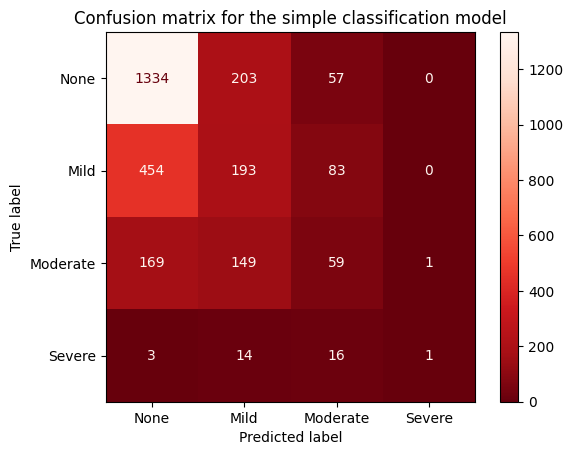

In [17]:
ConfusionMatrixDisplay.from_predictions(y, oof, cmap='Reds_r')  
plt.title('Confusion matrix for the simple classification model')
plt.xticks(np.arange(4), target_labels)
plt.yticks(np.arange(4), target_labels)
plt.show()

In [18]:
#Regression
y = supervised_usable.get_column('sii')
X = supervised_usable.drop('id', 'sii', '^PCIAT.*$').to_pandas()

kf = StratifiedKFold(shuffle=True, random_state=1)
oof_raw = np.zeros(len(y), dtype=float) # oof predictions, before rounding
oof = np.zeros(len(y), dtype=int) # oof predictions, rounded
for fold, (idx_tr, idx_va) in enumerate(kf.split(X, y)):
    X_tr = X.iloc[idx_tr]
    X_va = X.iloc[idx_va]
    y_tr = y[idx_tr]
    y_va = y[idx_va]

    model = lightgbm.LGBMRegressor(verbose=-1)
    model.fit(X_tr, y_tr.to_numpy())
    y_pred = model.predict(X_va)
    oof_raw[idx_va] = y_pred
    y_pred = y_pred.round(0).astype(int)
    score = cohen_kappa_score(y_va, y_pred, weights='quadratic')
    print(f"# Fold {fold}: {score=:.3f}")
    oof[idx_va] = y_pred

score = cohen_kappa_score(y, oof, weights='quadratic')
print(f"{Fore.GREEN}{Style.BRIGHT}# Overall: {score=:.3f} (regression with LightGBM){Style.RESET_ALL}")


# Fold 0: score=0.360
# Fold 1: score=0.422
# Fold 2: score=0.355
# Fold 3: score=0.384
# Fold 4: score=0.426
# Overall: score=0.389 (regression with LightGBM)


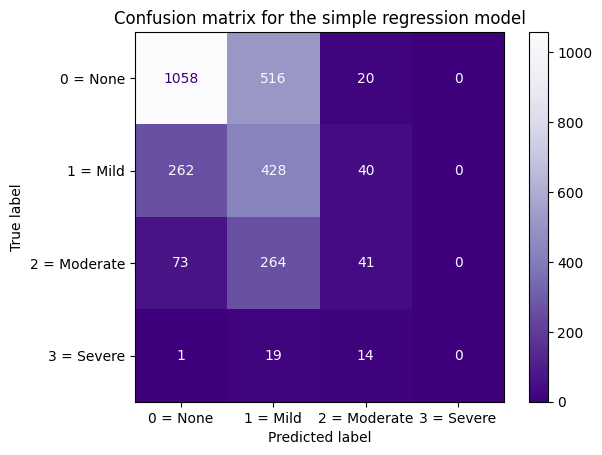

In [19]:
regression_labels = [f"{i} = {target_labels[i]}" for i in range(4)]

ConfusionMatrixDisplay.from_predictions(y, oof, cmap='Purples_r')
plt.title('Confusion matrix for the simple regression model')
plt.xticks(np.arange(4), regression_labels)
plt.yticks(np.arange(4), regression_labels)
plt.show()

### Tuning threshold

In [20]:
def round_with_thresholds(raw_preds, thresholds):
    return np.where(raw_preds < thresholds[0], 0,
                    np.where(raw_preds < thresholds[1], 1,
                             np.where(raw_preds < thresholds[2], 2, 3)))


thresholds_1 = [1, 2, 3]
thresholds_2 = [0.5, 1.5, 2.5]

oof_rounded_1 = round_with_thresholds(oof_raw, thresholds_1)
score_1 = cohen_kappa_score(y, oof_rounded_1, weights='quadratic')

oof_rounded_2 = round_with_thresholds(oof_raw, thresholds_2)
score_2 = cohen_kappa_score(y, oof_rounded_2, weights='quadratic')


print(f"# Score with thresholds [1, 2, 3]: {score_1:.3f}")
print(f"# Score with thresholds [0.5, 1.5, 2.5]: {score_2:.3f}")

# Score with thresholds [1, 2, 3]: 0.254
# Score with thresholds [0.5, 1.5, 2.5]: 0.389


# 4. Model Implementation

```
Params_LGB = {
   'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,  # Increased from 6.59
    'lambda_l2': 0.01,
    'verbose': -1
}

XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,
    'reg_lambda': 5,
    'random_state': 0,
    'tree_method': 'hist',  
}

CatBoost_Params = {
    'learning_rate': 0.05,
    'depth': 6,
    'iterations': 200,
    'random_seed': 0,
    'verbose': 0,
    'l2_leaf_reg': 10,
    'task_type': 'CPU' 
}
```

In [30]:
# calculate kappa
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

# define threshold for sii (0-3)
def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))
# evaluate kappa after rounded
def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

In [31]:
# function to automated optimize params for model members in voting regressor model
def optimize_model_params(model_name, X, y):
    def objective(trial):
        if model_name == 'lgb':
            params = {
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.046),
                'max_depth': trial.suggest_int('max_depth', 3, 12),
                'num_leaves': trial.suggest_int('num_leaves', 20, 478),
                'n_estimators': trial.suggest_int('n_estimators', 50, 200),
                'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 13),
                'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 0.893),
                'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 0.784),
                'bagging_freq': trial.suggest_int('bagging_freq', 1, 4),
                'lambda_l1': trial.suggest_float('lambda_l1', 0, 10),
                'lambda_l2': trial.suggest_float('lambda_l2', 0,0.01),
                'verbose': -1,
            }
            model = lgb.LGBMRegressor(**params)

        elif model_name == 'xgb':
            params = {
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
                'max_depth': trial.suggest_int('max_depth', 3, 6),
                'n_estimators': trial.suggest_int('n_estimators', 50,200),
                'subsample': trial.suggest_float('subsample', 0.5, 0.8),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.8),
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 10, ),
                'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
                'random_state': 0,
                'tree_method': 'hist',  
            }
            model = xgb.XGBRegressor(**params)

        elif model_name == 'catboost':
            params = {
                'learning_rate': trial.suggest_float('learning_rate', 0.01,0.05),
                'depth': trial.suggest_int('depth', 4,6),
                'iterations': trial.suggest_int('iterations', 50,200),
                'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1,10),
                'random_seed': 0,
                'verbose': 0,
                'task_type': 'CPU',
            }
            model = cb.CatBoostRegressor(**params)

        else:
            raise ValueError("Unsupported model")

        # Cross-validation to evaluate model performance
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
        scores = []
        for train_idx, val_idx in skf.split(X, y):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            model.fit(X_train, y_train)
            preds = model.predict(X_val).round(0).astype(int)
            scores.append(quadratic_weighted_kappa(y_val, preds))
        
        # Return negative of mean score for minimization
        return -np.mean(scores)

    # Create and optimize study
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=20)
    return study.best_params

In [32]:
# Training function
def ModelTraining(X, y, test_data):
    # Optimize parameters for each model
    lgb_params = optimize_model_params('lgb', X, y)
    xgb_params = optimize_model_params('xgb', X, y)
    catboost_params = optimize_model_params('catboost', X, y)

    # Initialize models with best params
    lgb_model = lgb.LGBMRegressor(**lgb_params)
    xgb_model = xgb.XGBRegressor(**xgb_params)
    catboost_model = cb.CatBoostRegressor(**catboost_params)

    # Voting Regressor
    voting_clf = VotingRegressor(
        estimators=[
            ('lgb', lgb_model),
            ('xgb', xgb_model),
            ('catboost', catboost_model),
        ]
    )

    # Stratified K-Fold
    SKF = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    oof_non_rounded = np.zeros(len(y), dtype=float)
    test_preds = np.zeros((len(test_data), 10))

    for fold, (train_idx, val_idx) in enumerate(tqdm(SKF.split(X, y),
                                        desc="Training Folds", total=10)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Fit Voting Regressor
        voting_clf.fit(X_train, y_train)

        # Predict
        oof_non_rounded[val_idx] = voting_clf.predict(X_val)
        test_preds[:, fold] = voting_clf.predict(test_data)

    # Optimize thresholds
    KappaOptimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5],
                              args=(y, oof_non_rounded),
                              method='Nelder-Mead')

    # Calculate final Kappa
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOptimizer.x)
    final_kappa = quadratic_weighted_kappa(y, oof_tuned)
    print(f"Optimized QWK Score: {final_kappa:.4f}")

    # Final predictions
    test_mean_preds = test_preds.mean(axis=1)
    final_preds = threshold_Rounder(test_mean_preds, KappaOptimizer.x)

    # Create submission
    submission = pd.DataFrame({
        'id': test_df['id'],
        'sii': final_preds
    })

    return submission

In [33]:
# define input
X = selected_df
y = usable_train_df['sii']
test_data_use = test.drop(columns="id")

# Submit

In [34]:
submission = ModelTraining(X, y, test_data_use)

[I 2024-12-21 02:30:48,818] A new study created in memory with name: no-name-6f84f87f-44f8-48b4-883e-24c504767e24
[I 2024-12-21 02:30:49,489] Trial 0 finished with value: -0.3845744067811044 and parameters: {'learning_rate': 0.03595207598260746, 'max_depth': 3, 'num_leaves': 97, 'n_estimators': 121, 'min_data_in_leaf': 6, 'feature_fraction': 0.833473623599035, 'bagging_fraction': 0.5936618183231782, 'bagging_freq': 4, 'lambda_l1': 1.645479259279029, 'lambda_l2': 0.006483616545749017}. Best is trial 0 with value: -0.3845744067811044.
[I 2024-12-21 02:30:50,617] Trial 1 finished with value: -0.36984845336935274 and parameters: {'learning_rate': 0.04477909590952408, 'max_depth': 8, 'num_leaves': 376, 'n_estimators': 55, 'min_data_in_leaf': 6, 'feature_fraction': 0.8218079137954524, 'bagging_fraction': 0.6092501640430685, 'bagging_freq': 2, 'lambda_l1': 4.986744430123063, 'lambda_l2': 0.008943762895131949}. Best is trial 0 with value: -0.3845744067811044.
[I 2024-12-21 02:30:52,192] Trial 

0:	learn: 0.7642485	total: 24.4ms	remaining: 4.39s
1:	learn: 0.7573999	total: 39ms	remaining: 3.49s
2:	learn: 0.7526337	total: 52.5ms	remaining: 3.12s
3:	learn: 0.7467278	total: 66.1ms	remaining: 2.92s
4:	learn: 0.7406166	total: 80.1ms	remaining: 2.82s
5:	learn: 0.7358431	total: 94.1ms	remaining: 2.74s
6:	learn: 0.7307329	total: 108ms	remaining: 2.69s
7:	learn: 0.7266689	total: 122ms	remaining: 2.65s
8:	learn: 0.7225287	total: 136ms	remaining: 2.6s
9:	learn: 0.7182445	total: 150ms	remaining: 2.57s
10:	learn: 0.7139687	total: 164ms	remaining: 2.54s
11:	learn: 0.7099539	total: 178ms	remaining: 2.51s
12:	learn: 0.7062212	total: 193ms	remaining: 2.5s
13:	learn: 0.7031893	total: 208ms	remaining: 2.48s
14:	learn: 0.7001130	total: 222ms	remaining: 2.45s
15:	learn: 0.6968908	total: 237ms	remaining: 2.44s
16:	learn: 0.6936545	total: 251ms	remaining: 2.42s
17:	learn: 0.6909835	total: 264ms	remaining: 2.39s
18:	learn: 0.6884169	total: 278ms	remaining: 2.37s
19:	learn: 0.6856667	total: 291ms	remai

Training Folds:  10%|█         | 1/10 [00:04<00:43,  4.82s/it]

0:	learn: 0.7643018	total: 19.7ms	remaining: 3.55s
1:	learn: 0.7575884	total: 30.8ms	remaining: 2.76s
2:	learn: 0.7528594	total: 41.3ms	remaining: 2.45s
3:	learn: 0.7467114	total: 52.1ms	remaining: 2.3s
4:	learn: 0.7415343	total: 62.8ms	remaining: 2.21s
5:	learn: 0.7363548	total: 73.7ms	remaining: 2.15s
6:	learn: 0.7312192	total: 84.3ms	remaining: 2.1s
7:	learn: 0.7266592	total: 95.1ms	remaining: 2.06s
8:	learn: 0.7223655	total: 106ms	remaining: 2.02s
9:	learn: 0.7181558	total: 116ms	remaining: 1.98s
10:	learn: 0.7139179	total: 127ms	remaining: 1.96s
11:	learn: 0.7104776	total: 138ms	remaining: 1.94s
12:	learn: 0.7071899	total: 148ms	remaining: 1.91s
13:	learn: 0.7039529	total: 159ms	remaining: 1.9s
14:	learn: 0.7010087	total: 169ms	remaining: 1.88s
15:	learn: 0.6980722	total: 180ms	remaining: 1.86s
16:	learn: 0.6949688	total: 191ms	remaining: 1.84s
17:	learn: 0.6923295	total: 201ms	remaining: 1.82s
18:	learn: 0.6893934	total: 211ms	remaining: 1.8s
19:	learn: 0.6866960	total: 222ms	rem

Training Folds:  20%|██        | 2/10 [00:09<00:35,  4.46s/it]

171:	learn: 0.5478039	total: 1.86s	remaining: 97.3ms
172:	learn: 0.5474397	total: 1.87s	remaining: 86.5ms
173:	learn: 0.5468959	total: 1.88s	remaining: 75.7ms
174:	learn: 0.5462161	total: 1.89s	remaining: 64.8ms
175:	learn: 0.5458079	total: 1.9s	remaining: 54ms
176:	learn: 0.5452968	total: 1.91s	remaining: 43.2ms
177:	learn: 0.5450023	total: 1.92s	remaining: 32.4ms
178:	learn: 0.5445117	total: 1.93s	remaining: 21.6ms
179:	learn: 0.5439287	total: 1.94s	remaining: 10.8ms
180:	learn: 0.5432102	total: 1.96s	remaining: 0us
0:	learn: 0.7628415	total: 20.6ms	remaining: 3.7s
1:	learn: 0.7564159	total: 31.6ms	remaining: 2.83s
2:	learn: 0.7513726	total: 42.2ms	remaining: 2.51s
3:	learn: 0.7452414	total: 52.7ms	remaining: 2.33s
4:	learn: 0.7399478	total: 63.3ms	remaining: 2.23s
5:	learn: 0.7349979	total: 74ms	remaining: 2.16s
6:	learn: 0.7303009	total: 84.5ms	remaining: 2.1s
7:	learn: 0.7260759	total: 95.2ms	remaining: 2.06s
8:	learn: 0.7219037	total: 106ms	remaining: 2.02s
9:	learn: 0.7178687	to

Training Folds:  30%|███       | 3/10 [00:13<00:31,  4.44s/it]

0:	learn: 0.7627918	total: 20.2ms	remaining: 3.63s
1:	learn: 0.7561004	total: 31.8ms	remaining: 2.85s
2:	learn: 0.7520122	total: 42.4ms	remaining: 2.51s
3:	learn: 0.7455625	total: 53.2ms	remaining: 2.35s
4:	learn: 0.7407463	total: 64ms	remaining: 2.25s
5:	learn: 0.7363570	total: 74.8ms	remaining: 2.18s
6:	learn: 0.7315380	total: 86.9ms	remaining: 2.16s
7:	learn: 0.7270784	total: 97.9ms	remaining: 2.12s
8:	learn: 0.7223591	total: 108ms	remaining: 2.07s
9:	learn: 0.7182705	total: 119ms	remaining: 2.03s
10:	learn: 0.7138496	total: 130ms	remaining: 2.01s
11:	learn: 0.7100881	total: 141ms	remaining: 1.98s
12:	learn: 0.7063834	total: 152ms	remaining: 1.97s
13:	learn: 0.7030610	total: 163ms	remaining: 1.95s
14:	learn: 0.7006452	total: 174ms	remaining: 1.92s
15:	learn: 0.6974874	total: 185ms	remaining: 1.9s
16:	learn: 0.6943848	total: 195ms	remaining: 1.88s
17:	learn: 0.6917309	total: 205ms	remaining: 1.86s
18:	learn: 0.6887931	total: 216ms	remaining: 1.84s
19:	learn: 0.6860523	total: 228ms	re

Training Folds:  40%|████      | 4/10 [00:17<00:26,  4.34s/it]

0:	learn: 0.7626680	total: 17.2ms	remaining: 3.1s
1:	learn: 0.7561629	total: 28.8ms	remaining: 2.58s
2:	learn: 0.7514084	total: 39.2ms	remaining: 2.32s
3:	learn: 0.7452610	total: 49.7ms	remaining: 2.2s
4:	learn: 0.7401194	total: 60.4ms	remaining: 2.13s
5:	learn: 0.7357983	total: 70.9ms	remaining: 2.07s
6:	learn: 0.7309867	total: 81.4ms	remaining: 2.02s
7:	learn: 0.7265968	total: 92.3ms	remaining: 2s
8:	learn: 0.7220009	total: 103ms	remaining: 1.97s
9:	learn: 0.7179193	total: 113ms	remaining: 1.94s
10:	learn: 0.7136368	total: 124ms	remaining: 1.92s
11:	learn: 0.7102187	total: 135ms	remaining: 1.91s
12:	learn: 0.7064352	total: 146ms	remaining: 1.89s
13:	learn: 0.7037263	total: 157ms	remaining: 1.87s
14:	learn: 0.7015254	total: 168ms	remaining: 1.86s
15:	learn: 0.6983524	total: 179ms	remaining: 1.84s
16:	learn: 0.6952971	total: 189ms	remaining: 1.82s
17:	learn: 0.6928472	total: 200ms	remaining: 1.81s
18:	learn: 0.6900115	total: 211ms	remaining: 1.79s
19:	learn: 0.6875420	total: 223ms	rema

Training Folds:  50%|█████     | 5/10 [00:21<00:21,  4.26s/it]

171:	learn: 0.5476374	total: 1.85s	remaining: 97.1ms
172:	learn: 0.5471925	total: 1.86s	remaining: 86.3ms
173:	learn: 0.5466845	total: 1.88s	remaining: 75.5ms
174:	learn: 0.5461524	total: 1.89s	remaining: 64.7ms
175:	learn: 0.5456971	total: 1.9s	remaining: 53.9ms
176:	learn: 0.5448891	total: 1.91s	remaining: 43.1ms
177:	learn: 0.5441674	total: 1.92s	remaining: 32.4ms
178:	learn: 0.5436108	total: 1.93s	remaining: 21.6ms
179:	learn: 0.5432753	total: 1.94s	remaining: 10.8ms
180:	learn: 0.5424992	total: 1.95s	remaining: 0us
0:	learn: 0.7629956	total: 16.8ms	remaining: 3.02s
1:	learn: 0.7567152	total: 28.1ms	remaining: 2.52s
2:	learn: 0.7519969	total: 38.5ms	remaining: 2.29s
3:	learn: 0.7460832	total: 49.4ms	remaining: 2.19s
4:	learn: 0.7406599	total: 60.2ms	remaining: 2.12s
5:	learn: 0.7357098	total: 70.6ms	remaining: 2.06s
6:	learn: 0.7313629	total: 81.2ms	remaining: 2.02s
7:	learn: 0.7274820	total: 92ms	remaining: 1.99s
8:	learn: 0.7234712	total: 102ms	remaining: 1.96s
9:	learn: 0.719263

Training Folds:  60%|██████    | 6/10 [00:25<00:16,  4.21s/it]

171:	learn: 0.5469619	total: 1.86s	remaining: 97.1ms
172:	learn: 0.5467362	total: 1.87s	remaining: 86.3ms
173:	learn: 0.5458613	total: 1.88s	remaining: 75.5ms
174:	learn: 0.5455273	total: 1.89s	remaining: 64.7ms
175:	learn: 0.5444726	total: 1.9s	remaining: 53.9ms
176:	learn: 0.5433671	total: 1.91s	remaining: 43.1ms
177:	learn: 0.5425261	total: 1.92s	remaining: 32.4ms
178:	learn: 0.5420182	total: 1.93s	remaining: 21.6ms
179:	learn: 0.5415998	total: 1.94s	remaining: 10.8ms
180:	learn: 0.5408849	total: 1.95s	remaining: 0us
0:	learn: 0.7645755	total: 17.3ms	remaining: 3.11s
1:	learn: 0.7583309	total: 28.5ms	remaining: 2.55s
2:	learn: 0.7534895	total: 39.1ms	remaining: 2.32s
3:	learn: 0.7474601	total: 49.8ms	remaining: 2.2s
4:	learn: 0.7427441	total: 60.9ms	remaining: 2.14s
5:	learn: 0.7377179	total: 72.1ms	remaining: 2.1s
6:	learn: 0.7329991	total: 83ms	remaining: 2.06s
7:	learn: 0.7290879	total: 94.5ms	remaining: 2.04s
8:	learn: 0.7247653	total: 105ms	remaining: 2.01s
9:	learn: 0.7205066	

Training Folds:  70%|███████   | 7/10 [00:30<00:12,  4.21s/it]

170:	learn: 0.5504596	total: 1.86s	remaining: 109ms
171:	learn: 0.5498288	total: 1.87s	remaining: 97.9ms
172:	learn: 0.5495773	total: 1.88s	remaining: 87ms
173:	learn: 0.5491644	total: 1.89s	remaining: 76.1ms
174:	learn: 0.5483365	total: 1.9s	remaining: 65.3ms
175:	learn: 0.5478776	total: 1.91s	remaining: 54.4ms
176:	learn: 0.5474429	total: 1.92s	remaining: 43.5ms
177:	learn: 0.5468803	total: 1.93s	remaining: 32.6ms
178:	learn: 0.5461485	total: 1.95s	remaining: 21.7ms
179:	learn: 0.5457388	total: 1.96s	remaining: 10.9ms
180:	learn: 0.5449543	total: 1.97s	remaining: 0us
0:	learn: 0.7642360	total: 17.4ms	remaining: 3.13s
1:	learn: 0.7577371	total: 29ms	remaining: 2.6s
2:	learn: 0.7522897	total: 40ms	remaining: 2.37s
3:	learn: 0.7464316	total: 50.9ms	remaining: 2.25s
4:	learn: 0.7411366	total: 61.8ms	remaining: 2.17s
5:	learn: 0.7365353	total: 72.9ms	remaining: 2.13s
6:	learn: 0.7316509	total: 83.6ms	remaining: 2.08s
7:	learn: 0.7270017	total: 94.4ms	remaining: 2.04s
8:	learn: 0.7220167	t

Training Folds:  80%|████████  | 8/10 [00:34<00:08,  4.27s/it]

171:	learn: 0.5432524	total: 2.06s	remaining: 108ms
172:	learn: 0.5424932	total: 2.07s	remaining: 95.8ms
173:	learn: 0.5416772	total: 2.09s	remaining: 83.9ms
174:	learn: 0.5412136	total: 2.1s	remaining: 72.1ms
175:	learn: 0.5407458	total: 2.12s	remaining: 60.1ms
176:	learn: 0.5403728	total: 2.13s	remaining: 48.1ms
177:	learn: 0.5398239	total: 2.14s	remaining: 36.1ms
178:	learn: 0.5392822	total: 2.16s	remaining: 24.1ms
179:	learn: 0.5387921	total: 2.17s	remaining: 12.1ms
180:	learn: 0.5383317	total: 2.18s	remaining: 0us
0:	learn: 0.7644642	total: 17.3ms	remaining: 3.1s
1:	learn: 0.7578861	total: 29ms	remaining: 2.59s
2:	learn: 0.7538154	total: 39.7ms	remaining: 2.35s
3:	learn: 0.7477171	total: 50.8ms	remaining: 2.25s
4:	learn: 0.7426160	total: 61.7ms	remaining: 2.17s
5:	learn: 0.7370170	total: 72.7ms	remaining: 2.12s
6:	learn: 0.7318901	total: 83.2ms	remaining: 2.07s
7:	learn: 0.7276257	total: 93.9ms	remaining: 2.03s
8:	learn: 0.7229814	total: 105ms	remaining: 2s
9:	learn: 0.7189055	tot

Training Folds:  90%|█████████ | 9/10 [00:38<00:04,  4.34s/it]

169:	learn: 0.5467261	total: 1.85s	remaining: 120ms
170:	learn: 0.5461909	total: 1.86s	remaining: 109ms
171:	learn: 0.5456914	total: 1.87s	remaining: 97.8ms
172:	learn: 0.5453176	total: 1.88s	remaining: 87ms
173:	learn: 0.5447307	total: 1.89s	remaining: 76.1ms
174:	learn: 0.5442182	total: 1.9s	remaining: 65.2ms
175:	learn: 0.5436589	total: 1.91s	remaining: 54.3ms
176:	learn: 0.5430676	total: 1.92s	remaining: 43.5ms
177:	learn: 0.5428681	total: 1.93s	remaining: 32.6ms
178:	learn: 0.5423493	total: 1.94s	remaining: 21.7ms
179:	learn: 0.5417990	total: 1.95s	remaining: 10.9ms
180:	learn: 0.5411986	total: 1.97s	remaining: 0us
0:	learn: 0.7648726	total: 17.4ms	remaining: 3.14s
1:	learn: 0.7581069	total: 28.9ms	remaining: 2.59s
2:	learn: 0.7532479	total: 39.5ms	remaining: 2.35s
3:	learn: 0.7472935	total: 50.7ms	remaining: 2.24s
4:	learn: 0.7421558	total: 62.2ms	remaining: 2.19s
5:	learn: 0.7376147	total: 73.1ms	remaining: 2.13s
6:	learn: 0.7333810	total: 83.7ms	remaining: 2.08s
7:	learn: 0.728

Training Folds: 100%|██████████| 10/10 [00:43<00:00,  4.31s/it]

171:	learn: 0.5481681	total: 1.85s	remaining: 96.9ms
172:	learn: 0.5476541	total: 1.86s	remaining: 86.2ms
173:	learn: 0.5469715	total: 1.87s	remaining: 75.4ms
174:	learn: 0.5467858	total: 1.88s	remaining: 64.6ms
175:	learn: 0.5464056	total: 1.89s	remaining: 53.8ms
176:	learn: 0.5458351	total: 1.9s	remaining: 43ms
177:	learn: 0.5454972	total: 1.91s	remaining: 32.3ms
178:	learn: 0.5448489	total: 1.93s	remaining: 21.5ms
179:	learn: 0.5444240	total: 1.94s	remaining: 10.8ms
180:	learn: 0.5438447	total: 1.95s	remaining: 0us


Optimized QWK Score: 0.4694


In [35]:
submission

,id,sii
0,00008ff9,1
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,0
5,001f3379,1
6,0038ba98,1
7,0068a485,0
8,0069fbed,1
9,0083e397,0


In [36]:
submission['sii'].value_counts()

sii
0    11
1     9
Name: count, dtype: int64

In [37]:
submission.to_csv("submission.csv", index=False)

## Improment compared to old version

| **Model version**         | **Kaggle Public Score** | **Runtime** | **Key improvement**                                                                                                                                                                                                                                                                                                      |
|----------------------------|-------------------------|-------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Test_CMI Version 4         | 0.194                  | 72.4s       | - It is the first model; actigraphy data was not used.<br>- Features chosen for selection were only 16 columns that have a correlation with Total_PCIAT: SDS-SDS_Total_Raw, BIA-BIA_BMI, FGC-FGC_TL, BIA-BIA_Frame_num, Physical-BMI, SDS-SDS_Total_T, BIA-BIA_FFMI, Physical-Height, FGC-FGC_SRL_Zone, PreInt_EduHx-computerinternet_hoursday, Basic_Demos-Age, Physical-Systolic_BP, FGC-FGC_CU, FGC-FGC_SRR_Zone, Physical-Weight, FGC-FGC_PU.<br>- The encoding of the season data failed (NaN values were not handled, so NaNs were set to 4 by default, which corresponds to the fifth season value). <br>- Use classification model, poor performence.|
| CMI_Updated Version 5      | 0.386                  | 176.7s      | - The issue with encoding the season data has been resolved.<br>- Actigraphy data was used and encoded using an AutoEncoder.<br>- The number of features selected for training (excluding Acti) is 29: Basic_Demos-Age, Physical-Systolic_BP, BIA-BIA_FFMI, BIA-BIA_BMI, FGC-FGC_SRR, Physical-Weight, Physical-Diastolic_BP, BIA-BIA_ICW, BIA-BIA_LST, SDS-SDS_Total_Raw, Physical-BMI, SDS-SDS_Total_T, FGC-FGC_SRR_Zone, FGC-FGC_PU_Zone, FGC-FGC_TL, CGAS-CGAS_Score, Basic_Demos-Sex, FGC-FGC_SRL, FGC-FGC_SRL_Zone, PAQ_C-Season, BIA-BIA_Activity_Level_num, Physical-Height, BIA-BIA_Frame_num, PreInt_EduHx-computerinternet_hoursday, BIA-BIA_SMM, BIA-BIA_DEE, BIA-BIA_FMI, FGC-FGC_PU, FGC-FGC_CU. <br>- Use regression model with better result in testing|
| CMI_Updated Version 8      | 0.394                  | 234.3s      | - All the features in Test data were chosen (58) then filtered with missing (remaining 48).                                                                                                                                                                                                                             |
| CMI_final                  | 0.399                  | 362.0s      | - Before training, construct a function to automated optimize model hyperparameters using Optuna to maximize the quadratic weighted Kappa (QWK) score.<br>- The optimize_model_params function defined parameter ranges for LightGBM, XGBoost, and CatBoost, using Stratified K-fold cross-validation to select the best parameters by minimizing the negative mean QWK score. |
